In [0]:
# File location and type
file_location = "/FileStore/tables/train.csv"
file_type = "csv"

# Import Module

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["figure.facecolor"]='white'

## Import Untuk Modul PySpark
from pyspark.sql.functions import *
from pyspark.sql.functions import expr
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col                    ## Null atau NaN
from pyspark.ml.feature import  StringIndexer                                ## Import untuk Label Encoding 
from pyspark.ml.feature import VectorAssembler                               ## untuk assembly beberapa nilai
from pyspark.ml.stat import Correlation                                      ## pearson correlation

# Label Encoding
from pyspark.ml  import Pipeline   

# Algoritma
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

# Tuning
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

# Evaluation of Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc

## Evaluator for Multiclass Classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import SparkContext


# Import Data

In [0]:
df= spark.read.csv(file_location, header=True, inferSchema=True)          ## gunakan option untuk read column name
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
PassengerId|Survived|Pclass| Name| Sex| Age|SibSp|Parch| Ticket| Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
 1| 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| A/5 21171| 7.25| null| S|
 2| 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0| PC 17599|71.2833| C85| C|
 3| 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0|STON/O2. 3101282| 7.925| null| S|
 4| 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 113803| 53.1| C123| S|
 5| 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 373450| 8.05| null| S|
 6| 0| 3| Moran, Mr. James| male|null| 0| 0| 330877| 8.4583| null| Q|
 7| 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0| 17463|51.8625| E46| S|
 8| 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 349909| 21.075| null| S|
 9| 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2| 347742|11.1333| null| S|
 10| 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0| 237736|30.0708| null| C|
 11| 1| 3|Sandstrom, Miss. ...|female| 4.0| 1| 1| PP 9549| 16.7| G6| S|
 12| 1| 1|Bonnell, Miss. El...|female|58.0| 0| 0| 113783| 26.55| C103| S|
 13| 0| 3|Saundercock, Mr. ...| male|20.0| 0| 0| A/5. 2151| 8.05| null| S|
 14| 0| 3|Andersson, Mr. An...| male|39.0| 1| 5| 347082| 31.275| null| S|
 15| 0| 3|Vestrom, Miss. Hu...|female|14.0| 0| 0| 350406| 7.8542| null| S|
 16| 1| 2|Hewlett, Mrs. (Ma...|female|55.0| 0| 0| 248706| 16.0| null| S|
 17| 0| 3|Rice, Master. Eugene| male| 2.0| 4| 1| 382652| 29.125| null| Q|
 18| 1| 2|Williams, Mr. Cha...| male|null| 0| 0| 244373| 13.0| null| S|
 19| 0| 3|Vander Planke, Mr...|female|31.0| 1| 0| 345763| 18.0| null| S|
 20| 1| 3|Masselmani, Mrs. ...|female|null| 0| 0| 2649| 7.225| null| C|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 20 rows

In [0]:
df.printSchema()

root
-- PassengerId: integer (nullable = true)
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Name: string (nullable = true)
-- Sex: string (nullable = true)
-- Age: double (nullable = true)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Ticket: string (nullable = true)
-- Fare: double (nullable = true)
-- Cabin: string (nullable = true)
-- Embarked: string (nullable = true)

# EDA

## Data Cleansing

Drop data yang tidak digunakan

In [0]:
# Cek Unique Value
unique_value_each_columns = [F.countDistinct(c).alias(c) for c in df.columns]
countdf =  df.select(*unique_value_each_columns)
countdf.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
 891| 2| 3| 891| 2| 88| 7| 7| 681| 248| 147| 3|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

In [0]:
# drop PassangerId, Name, Ticket
df = df.drop("PassengerId", "Ticket")
df.show()

+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Cabin|Embarked|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| null| S|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C85| C|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| null| S|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| C123| S|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| null| S|
 0| 3| Moran, Mr. James| male|null| 0| 0| 8.4583| null| Q|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| E46| S|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| null| S|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| null| S|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| null| C|
 1| 3|Sandstrom, Miss. ...|female| 4.0| 1| 1| 16.7| G6| S|
 1| 1|Bonnell, Miss. El...|female|58.0| 0| 0| 26.55| C103| S|
 0| 3|Saundercock, Mr. ...| male|20.0| 0| 0| 8.05| null| S|
 0| 3|Andersson, Mr. An...| male|39.0| 1| 5| 31.275| null| S|
 0| 3|Vestrom, Miss. Hu...|female|14.0| 0| 0| 7.8542| null| S|
 1| 2|Hewlett, Mrs. (Ma...|female|55.0| 0| 0| 16.0| null| S|
 0| 3|Rice, Master. Eugene| male| 2.0| 4| 1| 29.125| null| Q|
 1| 2|Williams, Mr. Cha...| male|null| 0| 0| 13.0| null| S|
 0| 3|Vander Planke, Mr...|female|31.0| 1| 0| 18.0| null| S|
 1| 3|Masselmani, Mrs. ...|female|null| 0| 0| 7.225| null| C|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+
only showing top 20 rows

Extract string data of each row with spesific word

In [0]:
## Extract string of Name(kolom) into Mr, Mrs, etc using regex
from pyspark.sql.functions import regexp_extract

df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.show(10)

+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Cabin|Embarked|Initial|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| null| S| Mr|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C85| C| Mrs|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| null| S| Miss|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| C123| S| Mrs|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| null| S| Mr|
 0| 3| Moran, Mr. James| male|null| 0| 0| 8.4583| null| Q| Mr|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| E46| S| Mr|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| null| S| Master|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| null| S| Mrs|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| null| C| Mrs|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
only showing top 10 rows

replacing value (column)

In [0]:
# df = df.replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
#                 ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'])


df = df.replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

df.show(10)

+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Cabin|Embarked|Initial|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| null| S| Mr|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C85| C| Mrs|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| null| S| Miss|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| C123| S| Mrs|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| null| S| Mr|
 0| 3| Moran, Mr. James| male|null| 0| 0| 8.4583| null| Q| Mr|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| E46| S| Mr|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| null| S| Master|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| null| S| Mrs|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| null| C| Mrs|
+--------+------+--------------------+------+----+-----+-----+-------+-----+--------+-------+
only showing top 10 rows

In [0]:
# Cek Unique Value
unique_value_each_columns = [F.countDistinct(c).alias(c) for c in df.columns]
countdf =  df.select(*unique_value_each_columns)
countdf.show()

+--------+------+----+---+---+-----+-----+----+-----+--------+-------+
Survived|Pclass|Name|Sex|Age|SibSp|Parch|Fare|Cabin|Embarked|Initial|
+--------+------+----+---+---+-----+-----+----+-----+--------+-------+
 2| 3| 891| 2| 88| 7| 7| 248| 147| 3| 5|
+--------+------+----+---+---+-----+-----+----+-----+--------+-------+

In [0]:
# Unique value
unique_classes = df.select('Initial').distinct().rdd.map(lambda x: x[0]).collect()
unique_classes

Out[10]: ['Miss', 'Other', 'Master', 'Mr', 'Mrs']

# EDA

In [0]:
## pie chart function

def pie_chart(data, kolom):
  plt.rcParams.update({'font.size': 14})
  data = data.toPandas()
  data[kolom].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=90)
  fig=plt.gcf()
  fig.set_size_inches(5,5)
  plt.title(kolom)
  plt.axis('off')
  plt.legend(data[kolom].value_counts(), title=kolom, loc='center right',  bbox_to_anchor=(1, 0, 0.5, 2))
  plt.show()

## Survived

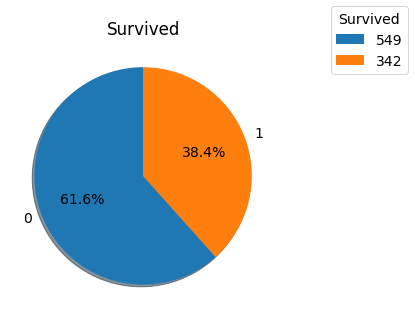

In [0]:
pie_chart(df, "Survived")

## Pclass

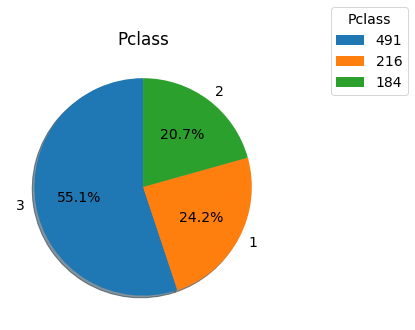

In [0]:
pie_chart(df, "Pclass")

## Sex

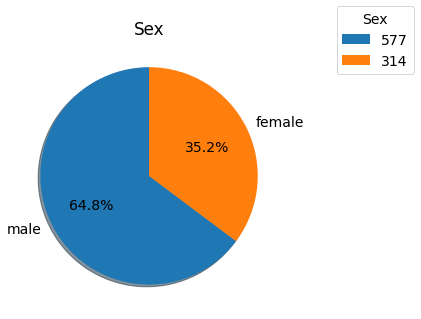

In [0]:
pie_chart(df, "Sex")

In [0]:
# Histogram Functions

def plot_histogram(data, kolom, jumlah_histogram, rot):
  variable_rdd_flatmap = data.select(kolom).rdd.flatMap(lambda x:x).histogram(jumlah_histogram)
  
  fig, ax = plt.subplots(figsize=(20,10), facecolor='w')
  plotting = pd.DataFrame(list(zip(*variable_rdd_flatmap)), columns=['bin','freq']).round(2).set_index('bin')
  plott = plotting.plot(kind='bar', ax=ax, rot=rot)
  return plott

## Age

Out[16]:

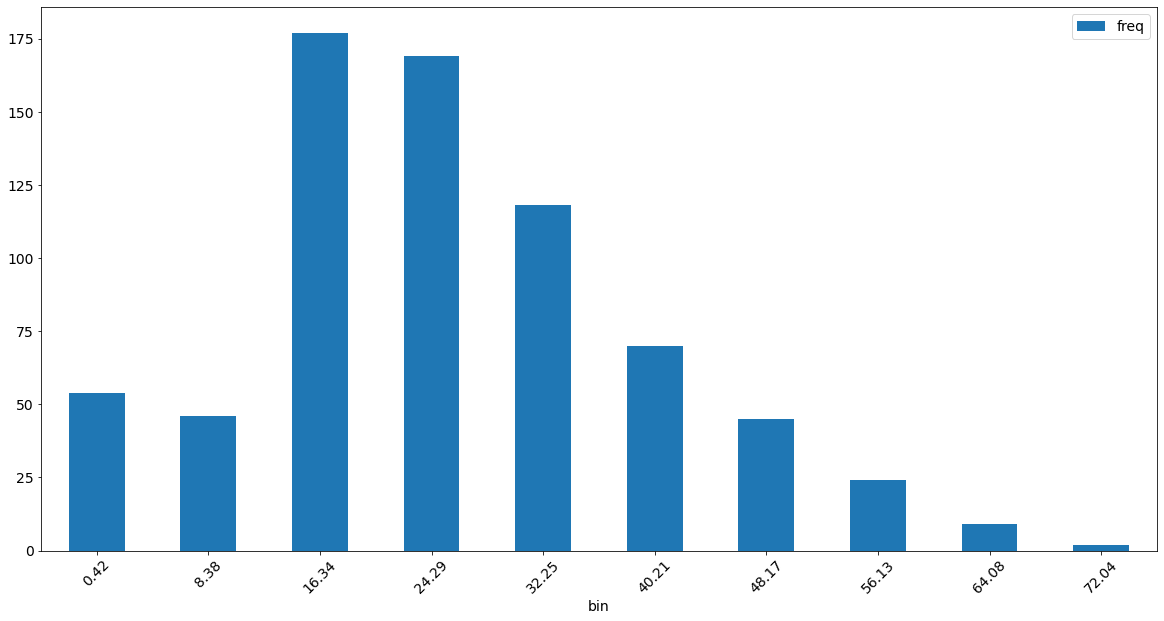

<matplotlib.axes._subplots.AxesSubplot at 0x7fb05c0d4eb0>

In [0]:
plot_histogram(df, "Age", 10, 45)

In [0]:
## pie chart function

def countplot (data, kolom, jenis_bar, rot):
  plt.rcParams.update({'font.size': 14})
  fig, ax = plt.subplots(figsize=(20,10), facecolor='w')
  data = data.toPandas()
  data = data[kolom].value_counts()
  data.sort_values(0, ascending=False).plot(kind=jenis_bar, ax=ax, rot=int(rot))
  plt.title(kolom)
  plt.show()

## SibSp

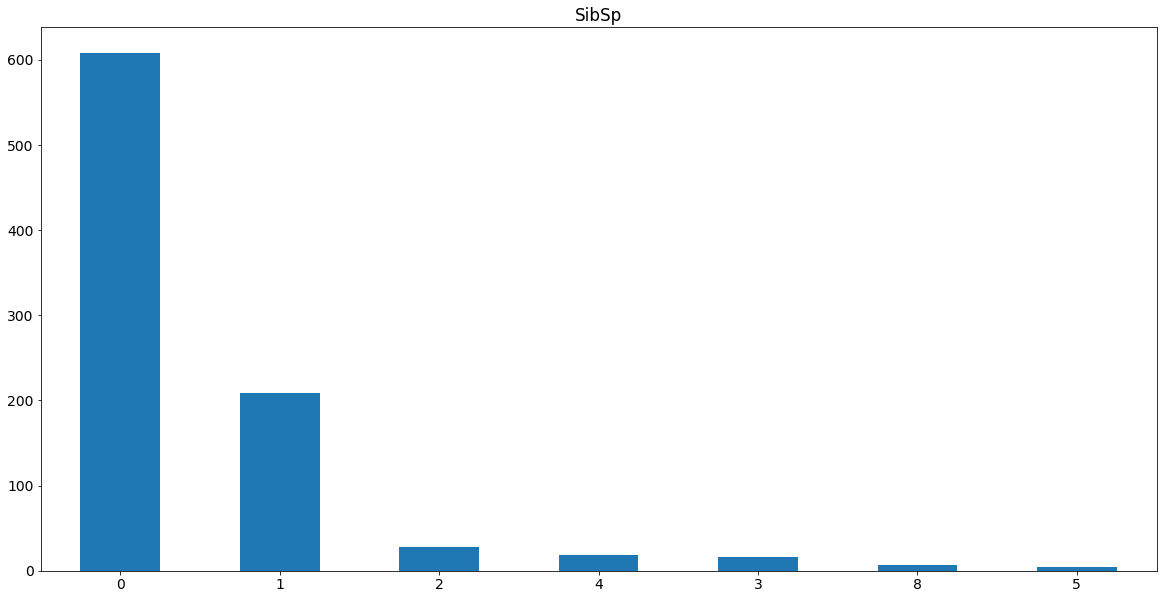

In [0]:
countplot(df, "SibSp", "bar", 0)

## Parch

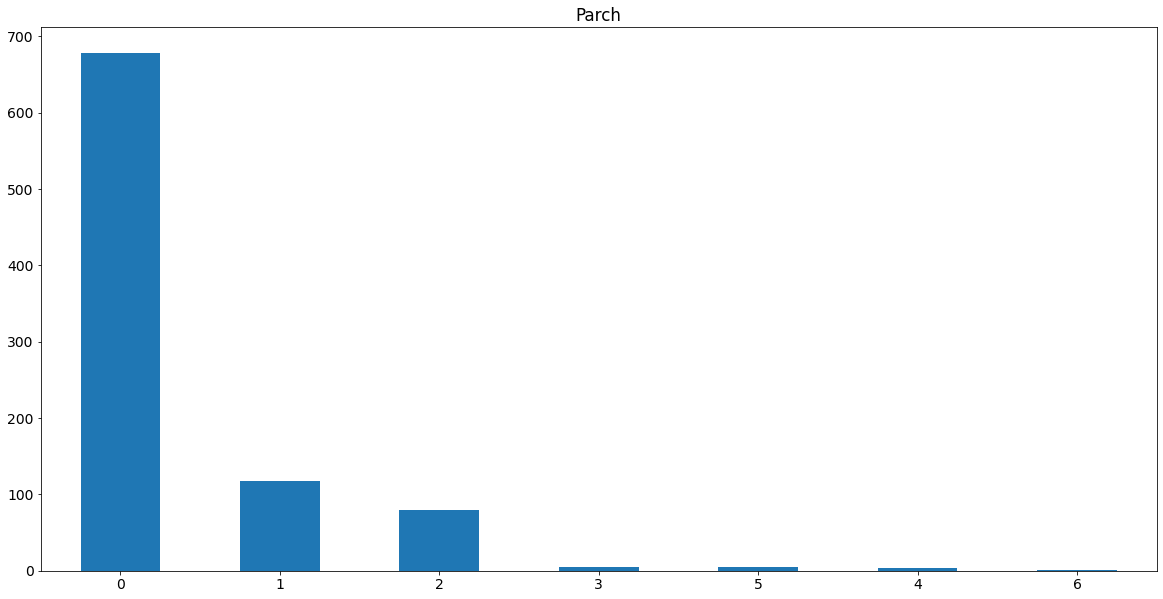

In [0]:
countplot(df, "Parch", "bar", 0)

## Fare

Out[20]:

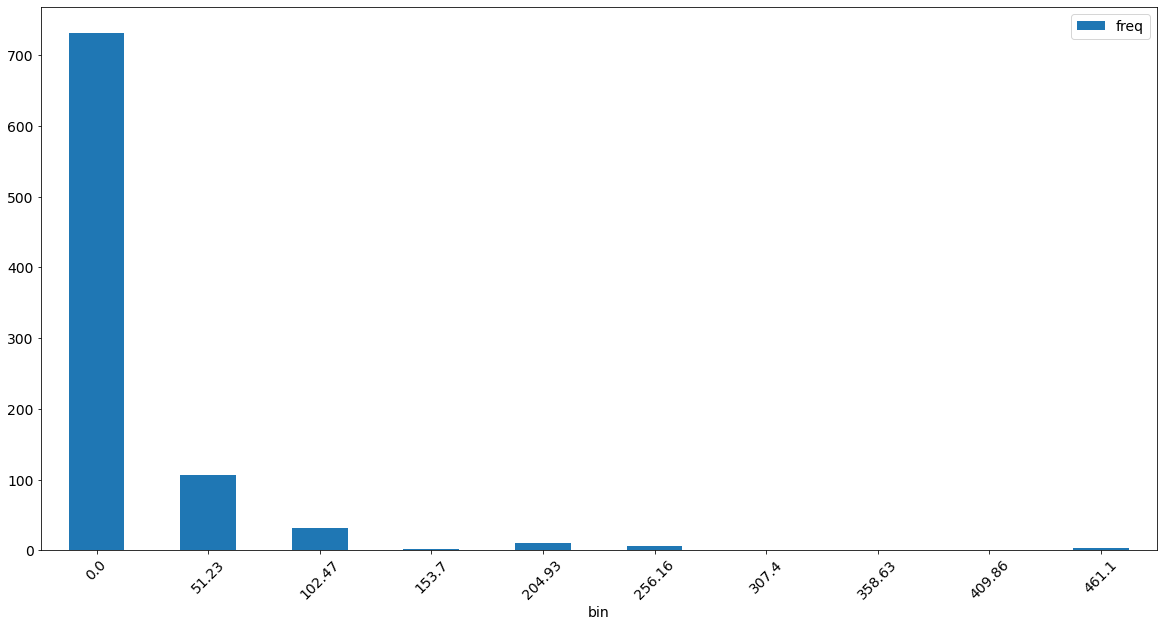

<matplotlib.axes._subplots.AxesSubplot at 0x7fb0578d90a0>

In [0]:
plot_histogram(df, "Fare", 10,  45)

### Embarked

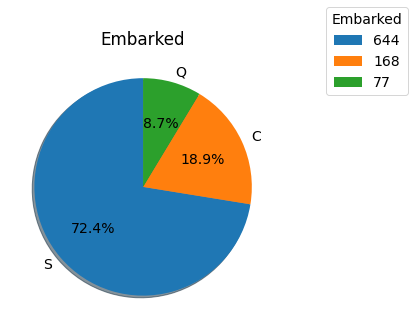

In [0]:
pie_chart(df, "Embarked")

## Handling Outlier

In [0]:
## cek missing value both of NaN or Null to all column

def percentage (data):
  l = []
  separator = ', '
  A = data.columns
  B = separator.join(A).split(",")
  n = len(A)
  
  for a in range (n):
    l.append("'{}'".format(A[a]) + "," + B[a])
    
  k = separator.join(l)

  ## tanpa percent
  tanpa_percent = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in A])
  spark_sql_without_percent = "stack(" + str(n) + ", "+ k + ") as (kolom, Null)"
  data_tanpa_percent = tanpa_percent.select(expr(spark_sql_without_percent))

  ## dengan percent
  dengan_percent = data.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in A])
  spark_sql_percent = "stack(" + str(n) + ", "+ k + ") as (kolom, Percentage_of_Null)"
  data_dengan_percent = dengan_percent.select(expr(spark_sql_percent))
  data_dengan_percent = data_dengan_percent.withColumn("Percentage_of_Null", round(col("Percentage_of_Null"), 2)) 
  
  ## Joining of 2 DataFrame based on "kolom" 
  df1 = data_tanpa_percent.alias('data_tanpa_percent')
  df2 = data_dengan_percent.alias('data_dengan_percent')

  data_final = df1.join(df2, df1.kolom == df2.kolom).select(df1[("*")], df2["Percentage_of_Null"])

  return data_final

In [0]:
null_data = percentage(df)
null_data.show()

+--------+----+------------------+
 kolom|Null|Percentage_of_Null|
+--------+----+------------------+
Survived| 0| 0.0|
 Pclass| 0| 0.0|
 Name| 0| 0.0|
 Sex| 0| 0.0|
 Age| 177| 0.2|
 SibSp| 0| 0.0|
 Parch| 0| 0.0|
 Fare| 0| 0.0|
 Cabin| 687| 0.77|
Embarked| 2| 0.0|
 Initial| 0| 0.0|
+--------+----+------------------+

In [0]:
df.count()

Out[24]: 891

In [0]:
df = df.drop("Cabin")
null_data = percentage(df)
null_data.show()

+--------+----+------------------+
 kolom|Null|Percentage_of_Null|
+--------+----+------------------+
Survived| 0| 0.0|
 Pclass| 0| 0.0|
 Name| 0| 0.0|
 Sex| 0| 0.0|
 Age| 177| 0.2|
 SibSp| 0| 0.0|
 Parch| 0| 0.0|
 Fare| 0| 0.0|
Embarked| 2| 0.0|
 Initial| 0| 0.0|
+--------+----+------------------+

In [0]:
## drop null value (kolom) in subset
# null_df.na.drop(subset=[‘Sales’]).show()

In [0]:
df.printSchema()

root
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Name: string (nullable = true)
-- Sex: string (nullable = true)
-- Age: double (nullable = true)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Fare: double (nullable = true)
-- Embarked: string (nullable = true)
-- Initial: string (nullable = true)

In [0]:
## Filling NaN using median

def fill_median (df, kolom):
  median = df.approxQuantile(kolom, [0.5], 0.25)
  median = median[0]
  df = df.na.fill(median, subset=[kolom])
  
  return df

In [0]:
df = fill_median(df, 'Age')
percentage(df).show()

+--------+----+------------------+
 kolom|Null|Percentage_of_Null|
+--------+----+------------------+
Survived| 0| 0.0|
 Pclass| 0| 0.0|
 Name| 0| 0.0|
 Sex| 0| 0.0|
 Age| 0| 0.0|
 SibSp| 0| 0.0|
 Parch| 0| 0.0|
 Fare| 0| 0.0|
Embarked| 2| 0.0|
 Initial| 0| 0.0|
+--------+----+------------------+

In [0]:
## Filling NaN using Mode(Modus)

## Finding Mode of each columns(multiple)
def mode_of_pyspark_columns(df, cat_col_list, verbose=False):
    col_with_mode=[]
    for col in cat_col_list:
      
        #Filter non-null
        df = df.filter(df[col].isNull()==False)
        
        #Find unique_values_with_count
        unique_classes = df.select(col).distinct().rdd.map(lambda x: x[0]).collect()
        
        ## Like Value counts in python but in the nested list
        unique_values_with_count=[]
        for uc in unique_classes:
             unique_values_with_count.append([uc, df.filter(df[col]==uc).count()])
            
        #sort unique values w.r.t their count values (Descending, big to small)
        sorted_unique_values_with_count= sorted(unique_values_with_count, key = lambda x: x[1], reverse =True)
        
        # Extract value of [0][0] meaning, first list ([0]), and first nested list([0], [0])
        if (verbose==True): print(col, sorted_unique_values_with_count, " and mode is ", sorted_unique_values_with_count[0][0])
          
        col_with_mode.append([col, sorted_unique_values_with_count[0][0]])
        
        return col_with_mode
      
      
## Filling each column using each mode by self (multiple)
def filling_mode (df, cat_col_list):
  mode_of_each_col = mode_of_pyspark_columns(df, cat_col_list)
  
  for col, mode in mode_of_each_col:
    df = df.withColumn(col, when(df[col].isNull()==True, lit(mode)).otherwise(df[col]))
    
    return df

In [0]:
df = filling_mode (df, ["Embarked"])
null_data = percentage(df)
null_data.show()

+--------+----+------------------+
 kolom|Null|Percentage_of_Null|
+--------+----+------------------+
Survived| 0| 0.0|
 Pclass| 0| 0.0|
 Name| 0| 0.0|
 Sex| 0| 0.0|
 Age| 0| 0.0|
 SibSp| 0| 0.0|
 Parch| 0| 0.0|
 Fare| 0| 0.0|
Embarked| 0| 0.0|
 Initial| 0| 0.0|
+--------+----+------------------+

# Feature Engineering

In [0]:
df.show(10)

+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Embarked|Initial|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| S| Mr|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C| Mrs|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| S| Miss|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| S| Mrs|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| S| Mr|
 0| 3| Moran, Mr. James| male|21.0| 0| 0| 8.4583| Q| Mr|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| S| Mr|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| S| Master|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| S| Mrs|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| C| Mrs|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+
only showing top 10 rows

In [0]:
## CREATE NEW VARIABLE

# Create new column: jumlah family
df = df.withColumn("Family_Size", col('SibSp')+col('Parch')) 

# Create new column(Alone), Note: ketika Family_Size=0 maka merupakan Alone(1), dst
df = df.withColumn('Alone',lit(0))  
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))
df.show()

+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Embarked|Initial|Family_Size|Alone|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| S| Mr| 1| 0|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C| Mrs| 1| 0|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| S| Miss| 0| 1|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| S| Mrs| 1| 0|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| S| Mr| 0| 1|
 0| 3| Moran, Mr. James| male|21.0| 0| 0| 8.4583| Q| Mr| 0| 1|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| S| Mr| 0| 1|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| S| Master| 4| 0|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| S| Mrs| 2| 0|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| C| Mrs| 1| 0|
 1| 3|Sandstrom, Miss. ...|female| 4.0| 1| 1| 16.7| S| Miss| 2| 0|
 1| 1|Bonnell, Miss. El...|female|58.0| 0| 0| 26.55| S| Miss| 0| 1|
 0| 3|Saundercock, Mr. ...| male|20.0| 0| 0| 8.05| S| Mr| 0| 1|
 0| 3|Andersson, Mr. An...| male|39.0| 1| 5| 31.275| S| Mr| 6| 0|
 0| 3|Vestrom, Miss. Hu...|female|14.0| 0| 0| 7.8542| S| Miss| 0| 1|
 1| 2|Hewlett, Mrs. (Ma...|female|55.0| 0| 0| 16.0| S| Mrs| 0| 1|
 0| 3|Rice, Master. Eugene| male| 2.0| 4| 1| 29.125| Q| Master| 5| 0|
 1| 2|Williams, Mr. Cha...| male|21.0| 0| 0| 13.0| S| Mr| 0| 1|
 0| 3|Vander Planke, Mr...|female|31.0| 1| 0| 18.0| S| Mrs| 1| 0|
 1| 3|Masselmani, Mrs. ...|female|21.0| 0| 0| 7.225| C| Mrs| 0| 1|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+
only showing top 20 rows

In [0]:
## Label Encoding (StringIndexer)
def label_encoding(data, lis_cat_var):
  indexers = [StringIndexer(inputCol=column,
                           outputCol=column+"_index").fit(data) for column in lis_cat_var]
  pipeline = Pipeline(stages=indexers)
  df = pipeline.fit(data).transform(data)
  
  return df

In [0]:
lis_var = ["Sex","Embarked","Initial"]

df = label_encoding(df, lis_var)
df.show()

+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+---------+--------------+-------------+
Survived|Pclass| Name| Sex| Age|SibSp|Parch| Fare|Embarked|Initial|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+---------+--------------+-------------+
 0| 3|Braund, Mr. Owen ...| male|22.0| 1| 0| 7.25| S| Mr| 1| 0| 0.0| 0.0| 0.0|
 1| 1|Cumings, Mrs. Joh...|female|38.0| 1| 0|71.2833| C| Mrs| 1| 0| 1.0| 1.0| 2.0|
 1| 3|Heikkinen, Miss. ...|female|26.0| 0| 0| 7.925| S| Miss| 0| 1| 1.0| 0.0| 1.0|
 1| 1|Futrelle, Mrs. Ja...|female|35.0| 1| 0| 53.1| S| Mrs| 1| 0| 1.0| 0.0| 2.0|
 0| 3|Allen, Mr. Willia...| male|35.0| 0| 0| 8.05| S| Mr| 0| 1| 0.0| 0.0| 0.0|
 0| 3| Moran, Mr. James| male|21.0| 0| 0| 8.4583| Q| Mr| 0| 1| 0.0| 2.0| 0.0|
 0| 1|McCarthy, Mr. Tim...| male|54.0| 0| 0|51.8625| S| Mr| 0| 1| 0.0| 0.0| 0.0|
 0| 3|Palsson, Master. ...| male| 2.0| 3| 1| 21.075| S| Master| 4| 0| 0.0| 0.0| 3.0|
 1| 3|Johnson, Mrs. Osc...|female|27.0| 0| 2|11.1333| S| Mrs| 2| 0| 1.0| 0.0| 2.0|
 1| 2|Nasser, Mrs. Nich...|female|14.0| 1| 0|30.0708| C| Mrs| 1| 0| 1.0| 1.0| 2.0|
 1| 3|Sandstrom, Miss. ...|female| 4.0| 1| 1| 16.7| S| Miss| 2| 0| 1.0| 0.0| 1.0|
 1| 1|Bonnell, Miss. El...|female|58.0| 0| 0| 26.55| S| Miss| 0| 1| 1.0| 0.0| 1.0|
 0| 3|Saundercock, Mr. ...| male|20.0| 0| 0| 8.05| S| Mr| 0| 1| 0.0| 0.0| 0.0|
 0| 3|Andersson, Mr. An...| male|39.0| 1| 5| 31.275| S| Mr| 6| 0| 0.0| 0.0| 0.0|
 0| 3|Vestrom, Miss. Hu...|female|14.0| 0| 0| 7.8542| S| Miss| 0| 1| 1.0| 0.0| 1.0|
 1| 2|Hewlett, Mrs. (Ma...|female|55.0| 0| 0| 16.0| S| Mrs| 0| 1| 1.0| 0.0| 2.0|
 0| 3|Rice, Master. Eugene| male| 2.0| 4| 1| 29.125| Q| Master| 5| 0| 0.0| 2.0| 3.0|
 1| 2|Williams, Mr. Cha...| male|21.0| 0| 0| 13.0| S| Mr| 0| 1| 0.0| 0.0| 0.0|
 0| 3|Vander Planke, Mr...|female|31.0| 1| 0| 18.0| S| Mrs| 1| 0| 1.0| 0.0| 2.0|
 1| 3|Masselmani, Mrs. ...|female|21.0| 0| 0| 7.225| C| Mrs| 0| 1| 1.0| 1.0| 2.0|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-------+-----------+-----+---------+--------------+-------------+
only showing top 20 rows

In [0]:
df.printSchema()

root
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Name: string (nullable = true)
-- Sex: string (nullable = true)
-- Age: double (nullable = false)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Fare: double (nullable = true)
-- Embarked: string (nullable = true)
-- Initial: string (nullable = true)
-- Family_Size: integer (nullable = true)
-- Alone: integer (nullable = false)
-- Sex_index: double (nullable = false)
-- Embarked_index: double (nullable = false)
-- Initial_index: double (nullable = false)

# Feature Selections

In [0]:
## drop variable yang tidak diperlukan
df = df.drop("Name","Embarked","Sex","Initial")
df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
Survived|Pclass| Age|SibSp|Parch| Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
 0| 3|22.0| 1| 0| 7.25| 1| 0| 0.0| 0.0| 0.0|
 1| 1|38.0| 1| 0|71.2833| 1| 0| 1.0| 1.0| 2.0|
 1| 3|26.0| 0| 0| 7.925| 0| 1| 1.0| 0.0| 1.0|
 1| 1|35.0| 1| 0| 53.1| 1| 0| 1.0| 0.0| 2.0|
 0| 3|35.0| 0| 0| 8.05| 0| 1| 0.0| 0.0| 0.0|
 0| 3|21.0| 0| 0| 8.4583| 0| 1| 0.0| 2.0| 0.0|
 0| 1|54.0| 0| 0|51.8625| 0| 1| 0.0| 0.0| 0.0|
 0| 3| 2.0| 3| 1| 21.075| 4| 0| 0.0| 0.0| 3.0|
 1| 3|27.0| 0| 2|11.1333| 2| 0| 1.0| 0.0| 2.0|
 1| 2|14.0| 1| 0|30.0708| 1| 0| 1.0| 1.0| 2.0|
 1| 3| 4.0| 1| 1| 16.7| 2| 0| 1.0| 0.0| 1.0|
 1| 1|58.0| 0| 0| 26.55| 0| 1| 1.0| 0.0| 1.0|
 0| 3|20.0| 0| 0| 8.05| 0| 1| 0.0| 0.0| 0.0|
 0| 3|39.0| 1| 5| 31.275| 6| 0| 0.0| 0.0| 0.0|
 0| 3|14.0| 0| 0| 7.8542| 0| 1| 1.0| 0.0| 1.0|
 1| 2|55.0| 0| 0| 16.0| 0| 1| 1.0| 0.0| 2.0|
 0| 3| 2.0| 4| 1| 29.125| 5| 0| 0.0| 2.0| 3.0|
 1| 2|21.0| 0| 0| 13.0| 0| 1| 0.0| 0.0| 0.0|
 0| 3|31.0| 1| 0| 18.0| 1| 0| 1.0| 0.0| 2.0|
 1| 3|21.0| 0| 0| 7.225| 0| 1| 1.0| 1.0| 2.0|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
only showing top 20 rows

In [0]:
## Pearson Correlations
def pearson_corr(data):
  columnList = [item[0] for item in data.dtypes if item[1].startswith('int') or item[1].startswith('double')]
  data = data.select(columnList)
  
  list_kolom = data.columns
  vector_col = 'corr_features'
  
  assembler = VectorAssembler(inputCols=list_kolom, outputCol=vector_col)
  myGraph_vector = assembler.transform(data).select(vector_col)
  
  matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
  corrmatrix = matrix.toArray().tolist()
  df = spark.createDataFrame(corrmatrix, list_kolom)

  return list_kolom, corrmatrix, df



def plot_corr_matrix(corrmatrix, attr):
    fig=plt.figure(figsize=(10,7))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(corrmatrix, vmax=1, vmin=-1)
    fig.colorbar(cax)
    plt.show()
    


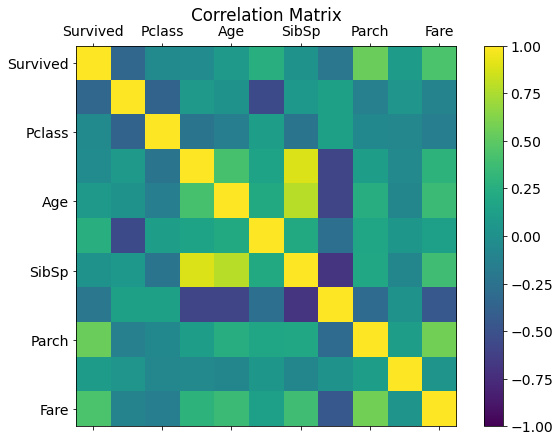

In [0]:
kolom_data, kormat, data_korelasi = pearson_corr(df)
plot_corr_matrix(kormat, kolom_data)

# Modelling

### Splitting Data (Target variable Survived)

In [0]:
df.show(10)

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
Survived|Pclass| Age|SibSp|Parch| Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
 0| 3|22.0| 1| 0| 7.25| 1| 0| 0.0| 0.0| 0.0|
 1| 1|38.0| 1| 0|71.2833| 1| 0| 1.0| 1.0| 2.0|
 1| 3|26.0| 0| 0| 7.925| 0| 1| 1.0| 0.0| 1.0|
 1| 1|35.0| 1| 0| 53.1| 1| 0| 1.0| 0.0| 2.0|
 0| 3|35.0| 0| 0| 8.05| 0| 1| 0.0| 0.0| 0.0|
 0| 3|21.0| 0| 0| 8.4583| 0| 1| 0.0| 2.0| 0.0|
 0| 1|54.0| 0| 0|51.8625| 0| 1| 0.0| 0.0| 0.0|
 0| 3| 2.0| 3| 1| 21.075| 4| 0| 0.0| 0.0| 3.0|
 1| 3|27.0| 0| 2|11.1333| 2| 0| 1.0| 0.0| 2.0|
 1| 2|14.0| 1| 0|30.0708| 1| 0| 1.0| 1.0| 2.0|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
only showing top 10 rows

In [0]:
df.columns[1:]

Out[41]: ['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Family_Size',
 'Alone',
 'Sex_index',
 'Embarked_index',
 'Initial_index']

In [0]:
feature_assembler = VectorAssembler(inputCols = df.columns[1:], outputCol="features")
feature_vector= feature_assembler.transform(df)
feature_vector.limit(3).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[42]:

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


# Splitting Data (Into Train and Test Data)

In [0]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)
train_df.show()

+--------+------+----+-----+-----+--------+-----------+-----+---------+--------------+-------------+--------------------+
Survived|Pclass| Age|SibSp|Parch| Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index| features|
+--------+------+----+-----+-----+--------+-----------+-----+---------+--------------+-------------+--------------------+
 0| 1| 2.0| 1| 2| 151.55| 3| 0| 1.0| 0.0| 1.0|[1.0,2.0,1.0,2.0,...|
 0| 1|18.0| 1| 0| 108.9| 1| 0| 0.0| 1.0| 0.0|[1.0,18.0,1.0,0.0...|
 0| 1|19.0| 1| 0| 53.1| 1| 0| 0.0| 0.0| 0.0|(10,[0,1,2,4,5],[...|
 0| 1|19.0| 3| 2| 263.0| 5| 0| 0.0| 0.0| 0.0|[1.0,19.0,3.0,2.0...|
 0| 1|21.0| 0| 0| 0.0| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,6],[1.0,...|
 0| 1|21.0| 0| 0| 26.0| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
 0| 1|21.0| 0| 0| 26.55| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
 0| 1|21.0| 0| 0| 27.7208| 0| 1| 0.0| 1.0| 0.0|(10,[0,1,4,6,8],[...|
 0| 1|21.0| 0| 0| 27.7208| 0| 1| 0.0| 1.0| 0.0|(10,[0,1,4,6,8],[...|
 0| 1|21.0| 0| 0| 30.6958| 0| 1| 0.0| 1.0| 0.0|(10,[0,1,4,6,8],[...|
 0| 1|21.0| 0| 0| 42.4| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
 0| 1|21.0| 0| 0|221.7792| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
 0| 1|21.0| 0| 0| 227.525| 0| 1| 0.0| 1.0| 0.0|(10,[0,1,4,6,8],[...|
 0| 1|21.0| 0| 1| 77.2875| 1| 0| 0.0| 0.0| 0.0|(10,[0,1,3,4,5],[...|
 0| 1|24.0| 0| 0| 79.2| 0| 1| 0.0| 1.0| 0.0|(10,[0,1,4,6,8],[...|
 0| 1|24.0| 0| 1|247.5208| 1| 0| 0.0| 1.0| 0.0|[1.0,24.0,0.0,1.0...|
 0| 1|25.0| 1| 2| 151.55| 3| 0| 1.0| 0.0| 2.0|[1.0,25.0,1.0,2.0...|
 0| 1|27.0| 0| 2| 211.5| 2| 0| 0.0| 1.0| 0.0|[1.0,27.0,0.0,2.0...|
 0| 1|28.0| 0| 0| 47.1| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
 0| 1|29.0| 0| 0| 30.0| 0| 1| 0.0| 0.0| 0.0|(10,[0,1,4,6],[1....|
+--------+------+----+-----+-----+--------+-----------+-----+---------+--------------+-------------+--------------------+
only showing top 20 rows

In [0]:
train_df.printSchema()

root
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Age: double (nullable = false)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Fare: double (nullable = true)
-- Family_Size: integer (nullable = true)
-- Alone: integer (nullable = false)
-- Sex_index: double (nullable = false)
-- Embarked_index: double (nullable = false)
-- Initial_index: double (nullable = false)
-- features: vector (nullable = true)

In [0]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])

# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])
train_df.show()

+--------------------+--------+
 features|Survived|
+--------------------+--------+
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 1|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 1|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 1|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 1|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
(10,[0,1,2,4,5],[...| 0|
+--------------------+--------+
only showing top 20 rows

In [0]:
train_df.limit(5).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[46]:

,features,Survived
0,"(1.0, 31.0, 1.0, 0.0, 52.0, 1.0, 0.0, 0.0, 0.0...",0
1,"(1.0, 31.0, 1.0, 0.0, 57.0, 1.0, 0.0, 0.0, 0.0...",1
2,"(1.0, 37.0, 1.0, 0.0, 53.1, 1.0, 0.0, 0.0, 0.0...",0
3,"(1.0, 38.0, 1.0, 0.0, 90.0, 1.0, 0.0, 0.0, 0.0...",1
4,"(1.0, 42.0, 1.0, 0.0, 52.0, 1.0, 0.0, 0.0, 0.0...",0


# Building Model

## 1. Logistic Regression

In [0]:
from pyspark.sql.types import FloatType


## Building Model
def model(algoritma, grid_parameter, data_train, data_test, target):
  
  # DEFINE CROSS VALIDATION WITH PARAMETERS
  tvs = TrainValidationSplit(estimator= algoritma, 
                             estimatorParamMaps= grid_parameter, 
                             evaluator=MulticlassClassificationEvaluator(labelCol = target), 
                             trainRatio=0.8)
  
  model = tvs.fit(data_train)
  model_predictions= model.transform(data_test)
  
  return model_predictions



# Getting Score 
def SCORE (model_predictions, target):
  
  # 1. AKURASI
  akurasi = MulticlassClassificationEvaluator(
    labelCol='Survived',metricName='accuracy').evaluate(model_predictions)
  akurasi = "{:.2f}".format(akurasi)
  
  # 2.a. PRESISI (Weighted)
  presisi_bobot = MulticlassClassificationEvaluator(
    labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions)
  presisi_bobot = "{:.2f}".format(presisi_bobot)
  
  # 2.b. PRESISI (Macro / imbalanced cases)
  presisi_makro = MulticlassClassificationEvaluator(
    labelCol='Survived',metricName='precisionByLabel').evaluate(model_predictions)
  presisi_makro = "{:.2f}".format(presisi_makro)
  
  
  # 3. Recall (Macro / imbalanced cases)
  recall_makro = MulticlassClassificationEvaluator(
    labelCol='Survived',metricName='recallByLabel').evaluate(model_predictions)
  recall_makro = "{:.2f}".format(recall_makro)
  
  
  # 4. F1 (Macro / imbalanced cases)
  F1_makro = MulticlassClassificationEvaluator(
    labelCol='Survived',metricName='fMeasureByLabel').evaluate(model_predictions)
  F1_makro = "{:.2f}".format(F1_makro)
  
  
  # 5. AUC_ROC
  sc = SparkContext.getOrCreate()
  result = model_predictions.select(['probability', target])
  
  ## collect setiap rownya
  hasil_collecting = result.collect()
  results_list = []
  
  for i in hasil_collecting:
    list_hasil = (float(i[0][0]), 1.0-float(i[1]))
    results_list.append(list_hasil)
    
  scoreAndLabels = sc.parallelize(results_list)
  metrics = metric(scoreAndLabels)
  nilai_ROC = metrics.areaUnderROC
  nilai_ROC = "{:.2f}".format(nilai_ROC)
  
  
  
  # 6. PLOT AUC
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  
  y_test = [i[1] for i in results_list]
  y_score = [i[0] for i in results_list]
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)
  
  %matplotlib inline
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Area under the ROC Curve')
  plt.legend(loc="lower right")
  plt.show()
  
  
  # 7. CONFUSION MATRIX
  preds_and_labels = model_predictions.select(
    ['prediction', target]).withColumn('label',F.col(target).cast(FloatType())).orderBy('prediction')
  
  preds_and_labels = preds_and_labels.select(['prediction','label'])
  metrics_multiclass = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  cm = metrics_multiclass.confusionMatrix().toArray()
  
  plt.figure(figsize = (10,7))
  sns.heatmap(cm, annot=True)
  
  
  return print('akurasi :', akurasi), print('presisi :', presisi_makro), print("recall :", recall_makro), print("F1 :", F1_makro), print('ROC Score :', nilai_ROC)



In [0]:
## Logistic Regression

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

In [0]:
model_lr = model(lr, paramGrid, train_df, test_df, "Survived")
model_lr

Out[96]: DataFrame[features: vector, Survived: int, rawPrediction: vector, probability: vector, prediction: double]

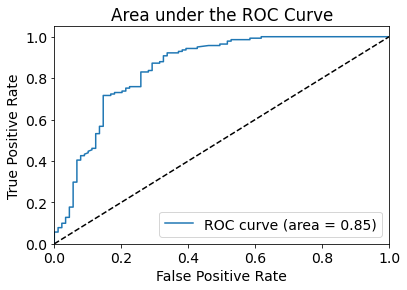

akurasi : 0.81
presisi : 0.81
recall : 0.90
F1 : 0.86
ROC Score : 0.85

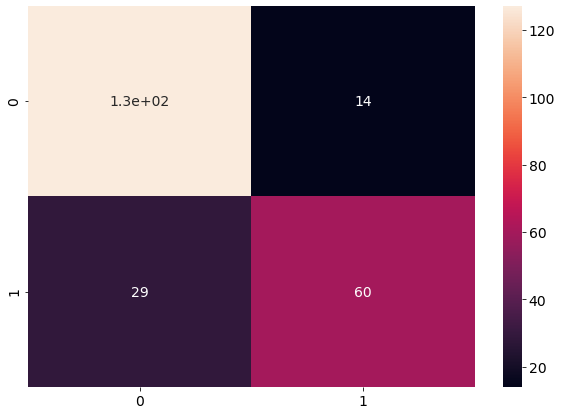

In [0]:
## Score
model_logistic = SCORE(model_lr, 'Survived')

## 2. RF

In [0]:
rf = RandomForestClassifier(labelCol='Survived')

paramGrid_rf = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 20]) \
                              .addGrid(rf.maxBins, [20, 32, 50]) \
                              .addGrid(rf.numTrees, [20, 40, 60 ]) \
                              .addGrid(rf.impurity, ["gini", "entropy"]) \
                              .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                              .build()

In [0]:
model_rf = model(rf, paramGrid_rf, train_df, test_df, "Survived")
model_rf

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Out[60]: DataFrame[features: vector, Survived: int, rawPrediction: vector, probability: vector, prediction: double]

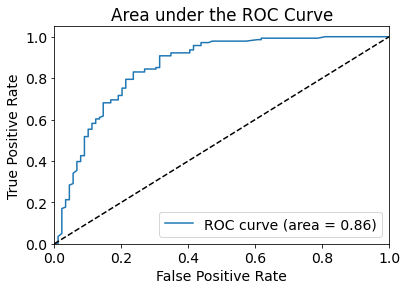

akurasi : 0.81
presisi : 0.81
recall : 0.91
F1 : 0.85
ROC Score : 0.86

In [0]:
## Score
model_random_forest = SCORE(model_rf, 'Survived')

## 3. Gradient Boosting Classifier

In [0]:
GB_class = GBTClassifier(labelCol="Survived")
paramGrid_GradientBoost = ParamGridBuilder().addGrid(GB_class.maxDepth, [5, 10, 20]) \
                                            .addGrid(GB_class.maxBins, [20, 32, 50]) \
                                            .addGrid(GB_class.maxIter, [10, 20, 30]) \
                                            .addGrid(GB_class.minInstancesPerNode, [1, 5, 10]) \
                                            .build()

model_GB = model(GB_class, paramGrid_GradientBoost, train_df, test_df, "Survived")
model_GB

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
## Score
SCORE_model_GB = SCORE(model_GB, 'Survived')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-232692831056334> in <module> 
 1 ## Score 
 ----> 2 SCORE_model_GB = SCORE ( model_GB , 'Survived' ) 

 NameError : name 'model_GB' is not defined

In [0]:
model_lr.show(10)

+--------------------+--------+--------------------+--------------------+----------+
 features|Survived| rawPrediction| probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
(10,[0,1,2,4,5],[...| 0|[0.80907675750378...|[0.69191273203593...| 0.0|
(10,[0,1,2,4,5],[...| 1|[0.84791124481392...|[0.70012879492541...| 0.0|
(10,[0,1,2,4,5],[...| 0|[0.77177361837317...|[0.68390443806476...| 0.0|
(10,[0,1,2,4,5],[...| 0|[0.72785627319277...|[0.67433467031963...| 0.0|
(10,[0,1,2,4,5],[...| 0|[0.74213478265810...|[0.67746249793190...| 0.0|
(10,[0,1,2,4,5],[...| 1|[0.95684665349158...|[0.72249000862231...| 0.0|
(10,[0,1,2,4,5],[...| 1|[0.54567348025201...|[0.63313122405281...| 0.0|
(10,[0,1,2,4,5],[...| 0|[1.32024977223805...|[0.78922325911221...| 0.0|
(10,[0,1,2,4,5],[...| 1|[2.16691521122854...|[0.89723889346754...| 0.0|
(10,[0,1,2,4,5],[...| 0|[2.11978484957984...|[0.89281134151967...| 0.0|
+--------------------+--------+--------------------+--------------------+----------+
only showing top 10 rows

In [0]:
dt  = model_lr.select(['prediction', 'Survived'])
dt.show(10)

+----------+--------+
prediction|Survived|
+----------+--------+
 0.0| 0|
 0.0| 1|
 0.0| 0|
 0.0| 0|
 0.0| 0|
 0.0| 1|
 0.0| 1|
 0.0| 0|
 0.0| 1|
 0.0| 0|
+----------+--------+
only showing top 10 rows

In [0]:
tp = dt[(dt.Survived == 1) & (dt.prediction == 1)].count()
tn = dt[(dt.Survived == 0) & (dt.prediction == 0)].count()
fp = dt[(dt.Survived == 0) & (dt.prediction == 1)].count()
fn = dt[(dt.Survived == 1) & (dt.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", dt.count())


True Positives: 60
True Negatives: 127
False Positives: 14
False Negatives: 29
Total 230

In [0]:
from pyspark.sql.functions import col, struct

aab = dt.withColumn("AB", struct("Survived", "prediction"))
aab.show()

+----------+--------+--------+
prediction|Survived| AB|
+----------+--------+--------+
 0.0| 0|{0, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 0|{0, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 1|{1, 0.0}|
 0.0| 1|{1, 0.0}|
+----------+--------+--------+
only showing top 20 rows

In [0]:
dt.crosstab("Survived", "prediction", ).show()

+-------------------+---+---+
Survived_prediction|0.0|1.0|
+-------------------+---+---+
 1| 29| 60|
 0|127| 14|
+-------------------+---+---+